In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
from abcd_graph import Graph, ABCDParams
import random
import pickle
import os
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
import seaborn as sns

import sys
sys.path.append('../')
from CAS import *

# SNAP graphs

* Load SNAP dataset from a local pickle file with two components:
  * List of edges
  * List of communities

* Build igraph object 'G'

In [2]:
## read data
with open('../Datasets/DBLPFull.pkl', 'rb') as handle:
    b = pickle.load(handle)
Communities = b["Community lists"][:-1]
Edges = b['edges'][:-1]


In [3]:
# number of comms
print('number of GT communities:',len(Communities))

# community sizes
print('most common community sizes:')
print(Counter([len(x) for x in Communities]).most_common(10))

# number of edges
print('\nnumber of edges:',len(Edges))
G = ig.Graph.TupleList([tuple(e) for e in Edges])

# Dictionary: node name to node id
v_dct = {j:i for i,j in enumerate(G.vs['name'])}
print('number of nodes:',G.vcount(),'\n')

# store all communities for each node
for v in G.vs:
    v['comms'] = []
## append communities in 1-based format (we keep 0 for the outliers - no communities)
for i in range(len(Communities)):
    for v in Communities[i]:
        G.vs[v_dct[v]]['comms'].append(i+1)
G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
print('Number of memberships (most frequent):')
print(Counter(G.vs['n_comms']).most_common(10), '\n')

## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

## Add pseudo single community ground truth: pick community with highest dev_A(v) for each v
G.vs['gt'] = [v['comms'][np.argmax(v['degrees'])] if len(v['degrees'])>0 else 0 for v in G.vs]


number of GT communities: 13477
most common community sizes:
[(6, 3680), (7, 2195), (8, 1461), (9, 1005), (10, 747), (11, 564), (12, 391), (13, 310), (14, 244), (16, 204)]

number of edges: 1049866
number of nodes: 317080 

Number of memberships (most frequent):
[(1, 150192), (0, 56082), (2, 43279), (3, 20163), (4, 11770), (5, 7909), (6, 5513), (7, 3915), (8, 3011), (9, 2332)] 



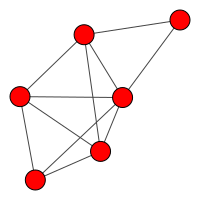

In [4]:
## Example of a community
V = [v_dct[x] for x in Communities[7]]
SG = G.subgraph(V)
ig.plot(SG, bbox=(200,200))


In [5]:
## Compute the external edge fraction given communities for each node
C = Counter([len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms'])))>0 for e in G.es])
print('xi_hat =',C[0]/(C[0]+C[1]))


xi_hat = 0.1088738943827117


### Clustering

* Leiden and compare with (single-community) GT


In [6]:
%%time
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
print('number of communities found:',max(G.vs['leiden']))
print('AMI:',AMI(G.vs['gt'], G.vs['leiden']))


number of communities found: 222
AMI: 0.28636111260356856
CPU times: user 3.33 s, sys: 28.1 ms, total: 3.36 s
Wall time: 3.35 s


### Post-processing

Compute the following measures and compare outliers found (no community ) with GT outliers:

* internal edge fraction (IEF)
* Beta score
* C score
* Pv (p-values) score


In [7]:
%%time
A = G.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(G.vs['leiden']), alpha=1)


CPU times: user 34.7 s, sys: 160 ms, total: 34.8 s
Wall time: 34.8 s


In [8]:
## Thresholds below are somewhat arbitrary

M = score_to_memberships(IEF, DegPart, threshold=.25)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('IEF:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Beta, DegPart, threshold=.25)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nBeta score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(C, DegPart, threshold=3)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nC score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Pv, DegPart, threshold=.95)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\np-value score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))


IEF:
outliers found: 52190
ground-truth outliers found: 17530

Beta score:
outliers found: 52297
ground-truth outliers found: 17530

C score:
outliers found: 52162
ground-truth outliers found: 17530

p-value score:
outliers found: 52138
ground-truth outliers found: 17530


In [9]:
## AMI with (single-community) GT
G.vs['IEF'] = IEF.argmax(axis=1).flatten().tolist()[0]
print('IEF:',AMI(G.vs['gt'], G.vs['IEF']))

G.vs['beta'] = Beta.argmax(axis=1).flatten().tolist()[0]
print('Beta:',AMI(G.vs['gt'], G.vs['beta']))

G.vs['C'] = C.argmax(axis=1).flatten().tolist()[0]
print('C score:',AMI(G.vs['gt'], G.vs['C']))

G.vs['Pv'] = Pv.argmax(axis=1).flatten().tolist()[0]
print('p-values:',AMI(G.vs['gt'], G.vs['Pv']))


IEF: 0.2877254936330903
Beta: 0.2870061681867281
C score: 0.28376301590837577
p-values: 0.2865448679755877


# Experiment with overlapping ground-truth (gt) communities

* Input: membership (sparse) matrix M and (Sparse) adjacency A


In [10]:
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i-1 for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, Beta, C, Pv, GedPart = CAS(A, M, alpha=1)


## k-communities

Look at nodes that are part of $k$ communities, with at least $l$ edges into each one of those, and compute average rank from each statistic


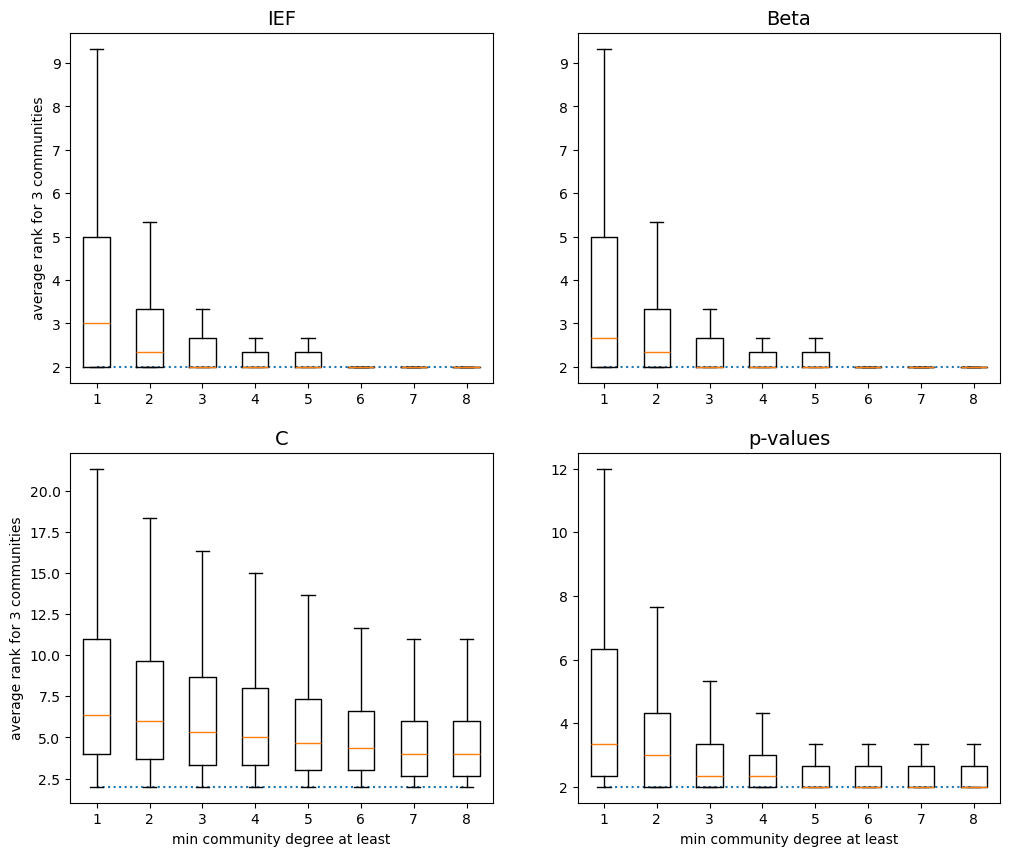

In [11]:
plt.style.use('default')
K = 3

V = np.array(G.vs['n_comms'])==K
GT = np.array([G.vs[v]['comms'] for v in np.where(V)])[0] -1 ## map 1-based to 0-based
Degs = np.array([G.vs[v]['degrees'] for v in np.where(V)])[0]
plt.figure(figsize=(12,10))

## IEF
X = IEF[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(221)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
plt.boxplot(my_dict.values(), showfliers=False)
#plt.xlabel('min community degree at least');
plt.ylabel('average rank for '+str(K)+' communities');
plt.title('IEF', fontsize=14);

## Beta
X = Beta[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(222)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
plt.boxplot(my_dict.values(), showfliers=False)
#plt.xlabel('min community degree at least');
#plt.ylabel('average rank for '+str(K)+' communities');
plt.title('Beta', fontsize=14);

## C
X = C[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(223)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
plt.boxplot(my_dict.values(), showfliers=False)
plt.xlabel('min community degree at least');
plt.ylabel('average rank for '+str(K)+' communities');
plt.title('C', fontsize=14);

## Pv
X = Pv[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(224)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
plt.boxplot(my_dict.values(), showfliers=False)
plt.xlabel('min community degree at least');
#plt.ylabel('average rank for '+str(K)+' communities');
plt.title('p-values', fontsize=14);

## save PNG
fn = 'dblp_'+str(K)+'.png'
plt.savefig(fn)


## Look at kth ranked communities

* proportion of k-th ranked community that is GT
* restrict to nodes with k+ communities and with 2+ community edges


In [12]:
MAX = 25
MINDEG = 2

NumIEF = np.zeros(MAX)
NumBeta = np.zeros(MAX)
NumC = np.zeros(MAX)
NumPv = np.zeros(MAX)
Den = np.zeros(MAX)

for K in (np.arange(MAX)+1):
    V = np.array(G.vs['n_comms'])>=K
    minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG
    V = V & minDeg
    Si = Sb = Sc = Sp = 0
    for i in range(len(V)):
        if V[i]:
            x = np.argsort(IEF[i].toarray()[0])[-K]
            Si += ((x+1) in G.vs[i]['comms'])
            x = np.argsort(Beta[i].toarray()[0])[-K]
            Sb += ((x+1) in G.vs[i]['comms'])
            x = np.argsort(C[i].toarray()[0])[-K]
            Sc += ((x+1) in G.vs[i]['comms'])
            x = np.argsort(Pv[i].toarray()[0])[-K]
            Sp += ((x+1) in G.vs[i]['comms'])
            
    NumBeta[K-1] = Sb
    NumC[K-1] = Sc
    NumIEF[K-1] = Si
    NumPv[K-1] = Sp
    Den[K-1] = sum(V)

    #print(K, Si, Sb, Sc, Sp, sum(V))

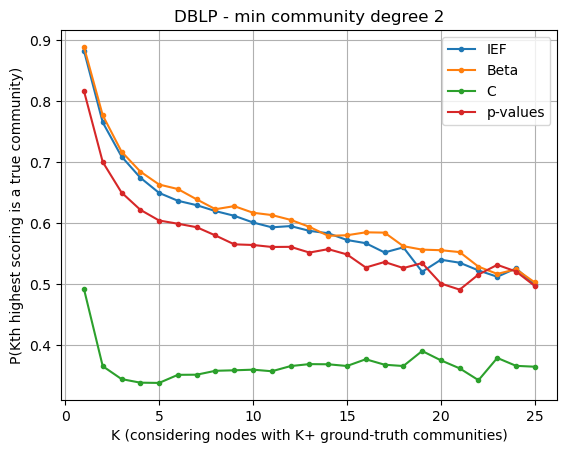

In [13]:
plt.plot(np.arange(MAX)+1, NumIEF/Den, '.-', label='IEF')
plt.plot(np.arange(MAX)+1, NumBeta/Den, '.-', label='Beta')
plt.plot(np.arange(MAX)+1, NumC/Den, '.-', label='C')
plt.plot(np.arange(MAX)+1, NumPv/Den, '.-', label='p-values')
plt.xlabel('K (considering nodes with K+ ground-truth communities)')
plt.ylabel('P(Kth highest scoring is a true community)')
plt.legend()
plt.grid()
plt.title('DBLP - min community degree 2')
fn = 'dblp_ranked_mindeg2.png'
plt.savefig(fn);


## Score distribution as function of community size

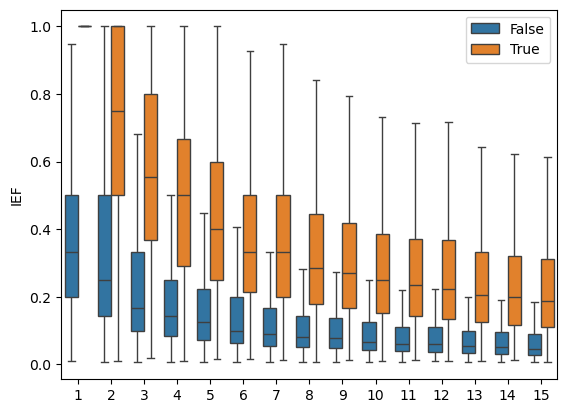

In [14]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = IEF[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['IEF','gt','number of communities'])

sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['IEF'], showfliers=False,
            hue = [bool(i) for i in D['gt']]);


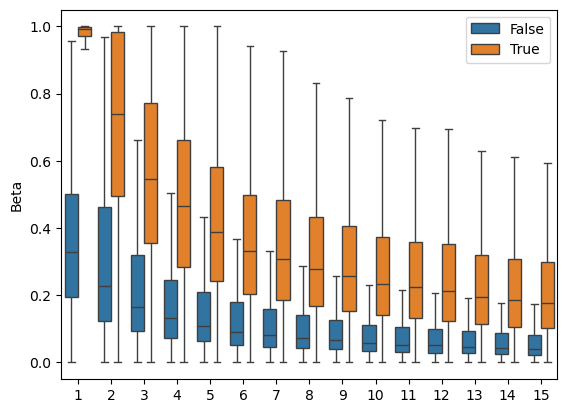

In [15]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Beta','gt','number of communities'])

sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['Beta'], showfliers=False,
            hue = [bool(i) for i in D['gt']]);


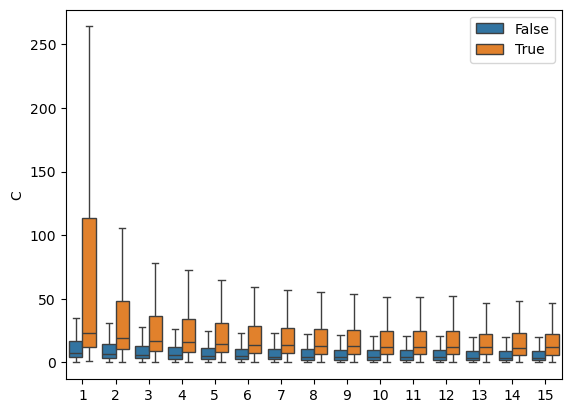

In [16]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = C[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['C','gt','number of communities'])

sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['C'], 
            hue = [bool(i) for i in D['gt']], showfliers=False );


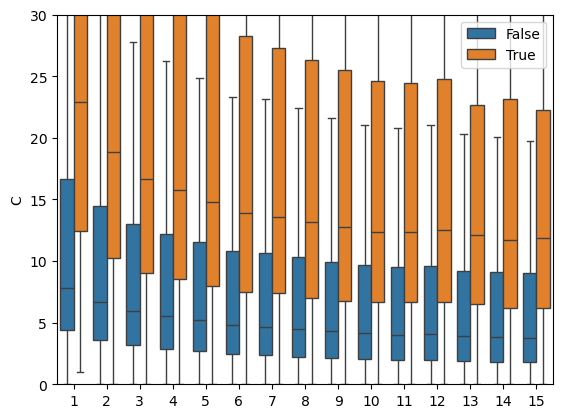

In [17]:
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['C'], 
            hue = [bool(i) for i in D['gt']], showfliers=False )
plt.ylim((0,30));


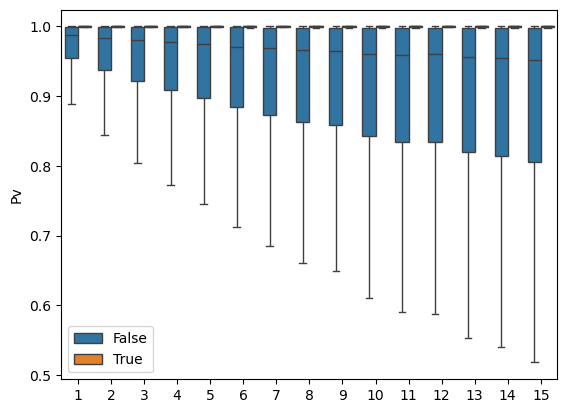

In [18]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Pv[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Pv','gt','number of communities'])

sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['Pv'], 
            hue = [bool(i) for i in D['gt']], showfliers=False );


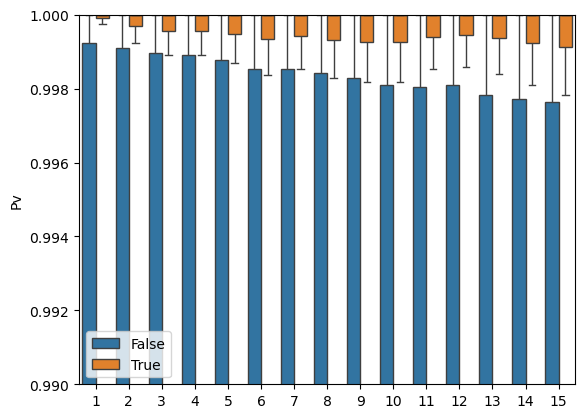

In [19]:
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['Pv'], 
            hue = [bool(i) for i in D['gt']], showfliers=False );
plt.ylim((.99,1));


## Absolute and Relative

Consider a node $i$ as part of a community $j$ if one of the folowing is true:

* $\beta_{i,j} \ge \beta^{*}$, for example $\beta^{*} = 0.5$
* $\beta_{i,j}$ is above $Q^{th}$ quantile of all values $\{\beta_{i,*} > 0\}$
* also min number of edges



In [20]:
## IQR
Q = betastar = .75
MINDEG = 2

gt = []
nc = []
total = []
minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG

for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    V = V & minDeg
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            th = min(np.quantile(x[x>0], Q), betastar)
            l = len(set(np.where(x>th)[0]).intersection(set(np.array(G.vs[i]['comms'])-1)))
            gt.append(l)
            total.append(sum(x>th))
            nc.append(ctr)
D = pd.DataFrame( np.array([total,gt,nc]).transpose(), columns=['total', 'gt', 'number of communities'])


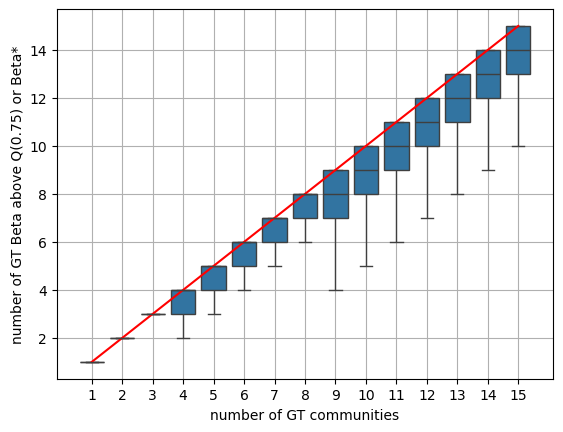

In [21]:
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['gt'], 
            showfliers=False );
plt.grid()
plt.xlabel('number of GT communities')
plt.ylabel('number of GT Beta above Q('+str(Q)+') or Beta*')
plt.plot([0,14],[1,15], color='red');


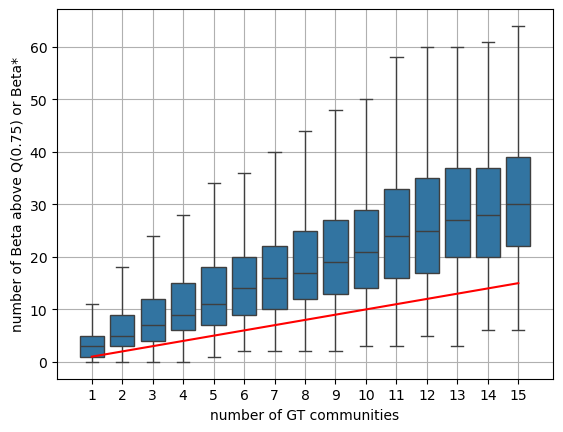

In [22]:
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['total'], 
            showfliers=False );
plt.grid()
plt.xlabel('number of GT communities')
plt.ylabel('number of Beta above Q('+str(Q)+') or Beta*')
plt.plot([0,14],[1,15], color='red');


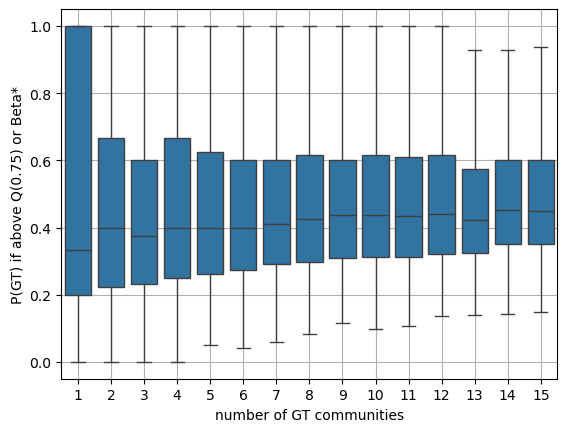

In [23]:
D['prop'] = D['gt'] / D['total']
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['prop'], 
            showfliers=False );
plt.grid()
plt.xlabel('number of GT communities')
plt.ylabel('P(GT) if above Q('+str(Q)+') or Beta*');
